### Pregunta de Negocio - Analistes de Finances i Risc Crediticio

> ¿Qué **umbrales de saldo** podrían indicar mayor **riesgo de morosidad**?
>

### Carga de datos

In [2]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency, norm, ttest_ind, f_oneway # Pruebas de hipótesis y análisis estadístico
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix,roc_curve, auc

import warnings
warnings.filterwarnings("ignore")#ignorar advertencias


#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

#### Carga de datos

In [23]:
df = pd.read_csv("../Data/df_250526.csv")

### Tratamiento previo de los datos
#### Para saldo que tiene muchos outliers, transformación logarítmica 
Reduce la asimetria de la variable y mejora la normalidad de la distribución, conservando el orden relativo de los valores.
#### Para default que tiene mucho sesgo, balanceo de clases
esto lo hacemos dentro de la función de entrenamiento del modelo, para que no afecte a la métrica de evaluación. (class_weight='balanced')

In [ ]:

# Evita problemas con valores negativos o cero
'''df['balance_log'] = np.log(df['balance'] + 1)
descartado me da valores NaN para los negativos'''

# Solo mantener registros con balance positivo
'''df['balance_log'] = df['balance'].apply(lambda x: np.log(x + 1) if x >= 0 else np.nan) 
Tambien descartado pues me quita los negativos y sigo con valores NaN'''
# transformacion simetrica logaritmica , para evitar valores NaN y mejorar la normalidad  conservar el signo de los valores negativos.
'''df['balance_log'] = df['balance'].apply(lambda x: np.sign(x) * np.log1p(abs(x))) 
Otro descarte pues me acumula artificialmente entorno a 0 lo que me da un pico en 0 y no me sirve para nada'''

#logaritmo hiperbólico inverso, para ver si logro eliminar el pico en 0
df['balance_log'] = np.arcsinh(df['balance'])
'''Al final acepte que hubiera pico en 0 pues en realidad los datos se concentran 
entorno a este valor por lo que me parece razonable
y no me afecta a la normalidad de la variable.'''

### Analisis descriptivo de saldo segun default
comparar la distribucion de saldo entre los clientes que han tenido default y los que no.

```python

In [25]:
promedio = df.groupby('default')['balance'].mean().round(2)
mediana = df.groupby('default')['balance'].median().round(2)
minimo = df.groupby('default')['balance'].min().round(2)
maximo = df.groupby('default')['balance'].max()
Descriptiva = pd.DataFrame({
    'Promedio': promedio,
    'Mediana': mediana,
    'Mínimo': minimo,
    'Máximo': maximo
})

promedio = df.groupby('default')['balance_log'].mean().round(2)
mediana = df.groupby('default')['balance_log'].median().round(2)
minimo = df.groupby('default')['balance_log'].min().round(2)
maximo = df.groupby('default')['balance_log'].max()
Descriptiva_log = pd.DataFrame({
    'Promedio': promedio,
    'Mediana': mediana,
    'Mínimo': minimo,
    'Máximo': maximo
})
print("Análisis descriptivo de la variable balance")
print(Descriptiva)
print("Analisis descriptivo de la variable balance_log")
print(Descriptiva_log)


Análisis descriptivo de la variable balance
         Promedio  Mediana  Mínimo  Máximo
default                                   
False     1531.93    559.0   -3058   81204
True       -87.75      0.0   -6847    5249
Analisis descriptivo de la variable balance_log
         Promedio  Mediana  Mínimo     Máximo
default                                      
False        5.94     7.02   -8.72  11.997867
True        -0.52     0.00   -9.52   9.258940


#### Comparativa de distribuciones de saldo original y con logaritmo

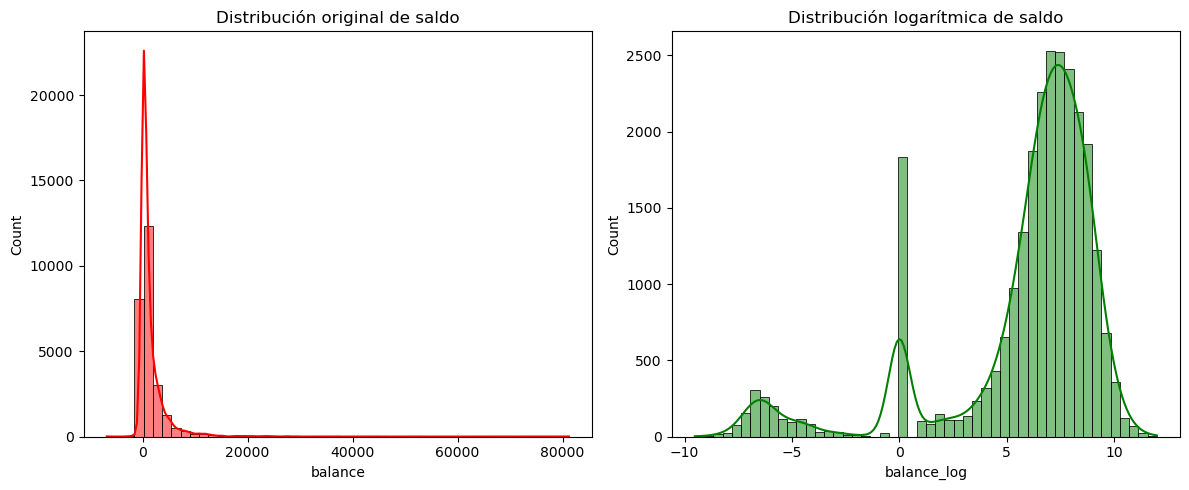

In [26]:
#  Crear rangos de balance para agrupar clientes en grupos iguales
df['balance_decile'] = pd.qcut(df['balance'], q=15, labels=False)
df['balance_log_decile'] = pd.qcut(df['balance_log'], q=15, labels=False)
# Visualizar la distribución de la variable 'balance' y su transformación logarítmica
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['balance'], bins=50, kde=True, ax=axes[0], color='red')
axes[0].set_title("Distribución original de saldo")

sns.histplot(df['balance_log'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title("Distribución logarítmica de saldo")

plt.tight_layout()
plt.show()


### Agupacion de saldos en rangos

Tasa global de incumplimiento: 0.0150
Tasa de incumplimiento por decil de saldo:
    balance_decile  default  indice_riesgo
0                1   0.0665           4.44
1                2   0.0288           1.92
2                3   0.0325           2.17
3                4   0.0166           1.11
4                5   0.0068           0.45
5                6   0.0122           0.81
6                7   0.0069           0.46
7                8   0.0006           0.04
8                9   0.0034           0.23
9               10   0.0040           0.27
10              11   0.0069           0.46
11              12   0.0000           0.00
12              13   0.0011           0.07
13              14   0.0000           0.00
14              15   0.0017           0.11
Tasa de incumplimiento por decil de saldo logarítmico:
    balance_log_decile  default  indice_riesgo
0                    1   0.0665           4.44
1                    2   0.0288           1.92
2                    3   0.0325    

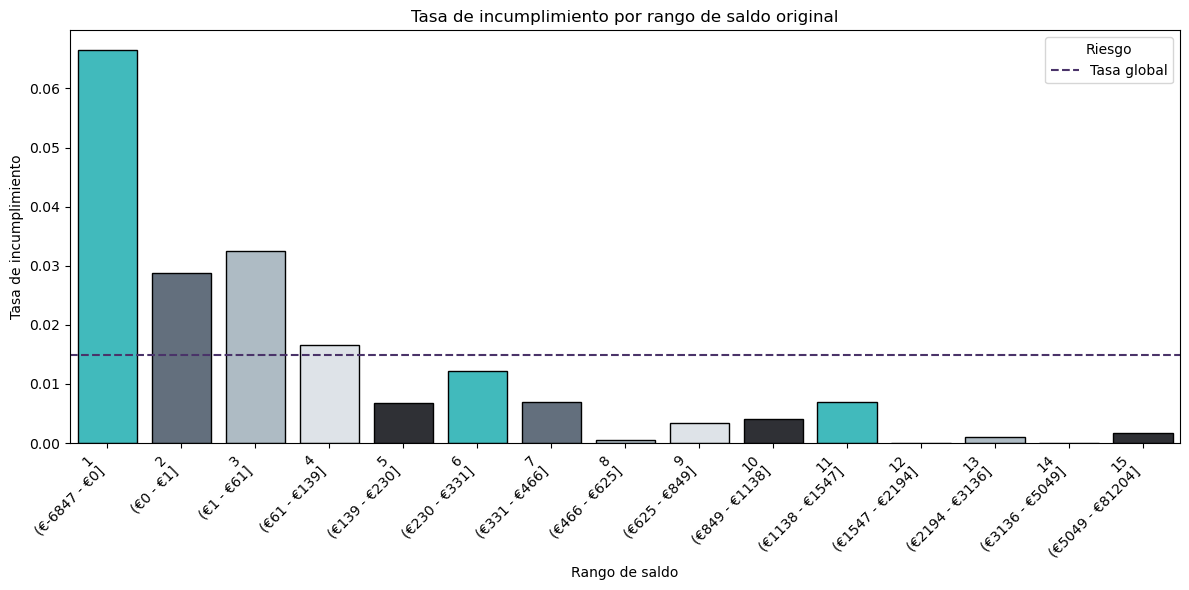

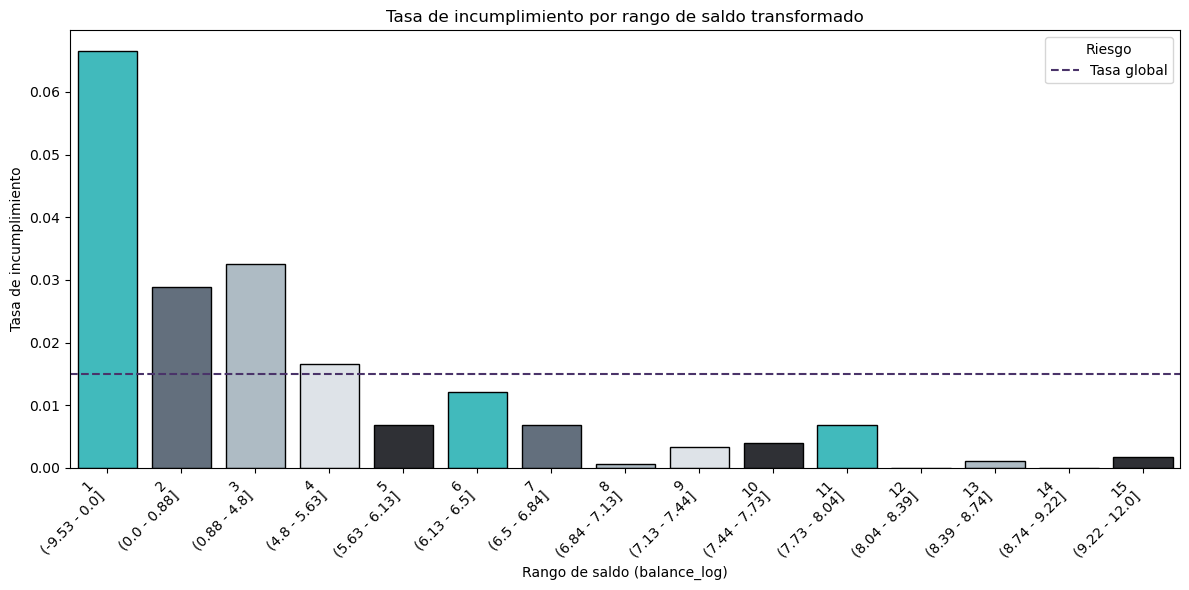

In [27]:


# Calcular la tasa de incumplimiento (default) por cada grupo de saldo
default_rates = (df.groupby('balance_decile')['default'].mean().reset_index()) #la media aritmética en ese grupo equivale a la proporción (o tasa) de incumplimiento
default_rates['default'] = default_rates['default'].round(4) 
default_rates['balance_decile'] = default_rates['balance_decile'] + 1
Tasa_global_impagos = df['default'].mean()
print(f"Tasa global de incumplimiento: {Tasa_global_impagos:.4f}")
# Calculamos el indice de riesgo por decil riesgo/riesgo global
default_rates['indice_riesgo'] = default_rates['default'] / Tasa_global_impagos
default_rates['indice_riesgo'] = default_rates['indice_riesgo'].round(2)

# === Balance transformado (logarítmico o arcsinh) ===
default_rates_log = df.groupby('balance_log_decile')['default'].mean().reset_index()
default_rates_log['default'] = default_rates_log['default'].round(4)
default_rates_log['balance_log_decile'] += 1
default_rates_log['indice_riesgo'] = (default_rates_log['default'] / Tasa_global_impagos).round(2)
df['balance_log_decile_range'] = pd.qcut(df['balance_log'], q=15, duplicates='drop')

#  Mostrar resultados en consola
print("Tasa de incumplimiento por decil de saldo:")
print(default_rates)
print('Tasa de incumplimiento por decil de saldo logarítmico:')
print(default_rates_log)
df['balance_decile_range'] = pd.qcut(df['balance'], q=15)

# Obtener los intervalos únicos en orden
balance_ranges = df['balance_decile_range'].cat.categories
decile_labels = [
    f"{i+1}\n(€{int(interval.left)} - €{int(interval.right)}]"
    for i, interval in enumerate(balance_ranges)
]

# Etiquetas para los deciles logarítmicos
balance_log_ranges = df['balance_log_decile_range'].cat.categories
decile_log_labels = [
    f"{i+1}\n({round(interval.left, 2)} - {round(interval.right, 2)}]"
    for i, interval in enumerate(balance_log_ranges)
]

#default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rates, x='balance_decile', y='default', palette=custom_palette, edgecolor='black')
plt.axhline(Tasa_global_impagos, color='#4A3369', linestyle='--', label='Tasa global')
plt.xticks(ticks=range(15), labels=decile_labels, rotation=45, ha='right')
plt.title('Tasa de incumplimiento por rango de saldo original')
plt.xlabel('Rango de saldo')
plt.ylabel('Tasa de incumplimiento')
plt.legend(title='Riesgo')
plt.tight_layout()
plt.show()


# Gráfico para balance_log
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rates_log, x='balance_log_decile', y='default', palette=custom_palette, edgecolor='black')
plt.axhline(Tasa_global_impagos, color='#4A3369', linestyle='--', label='Tasa global')
plt.xticks(ticks=range(len(decile_log_labels)), labels=decile_log_labels, rotation=45, ha='right')
plt.title('Tasa de incumplimiento por rango de saldo transformado')
plt.xlabel('Rango de saldo (balance_log)')
plt.ylabel('Tasa de incumplimiento')
plt.legend(title='Riesgo')
plt.tight_layout()
plt.show()



Según los datos más recientes del Banco de España, la tasa de morosidad de la banca española cerró 2024 en un 3,32%, la más baja desde finales de 2008 . Este indicador refleja el porcentaje de préstamos impagados en relación con el total de créditos concedidos.

### Preparacion entrenamiento

In [38]:
# data frame boleano
df_bool = df[['default', 'housing', 'loan', 'deposit', 'balance']].copy()


 

for col in ['default','housing', 'loan', 'deposit']:
    df_bool[col] = df_bool[col].astype(int)

# Definir las variables predictoras y la variable objetivo
X = df_bool[[ 'housing', 'loan']]
y = df_bool['default']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



### Regresion logistica

In [39]:
log_model = LogisticRegression(class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]
# Resultados
print("=== Regresión Logística ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

coefs = pd.Series(log_model.coef_[0], index=X.columns)
print("Coeficientes del modelo:")
print(coefs.sort_values(ascending=False))



=== Regresión Logística ===
[[6738  991]
 [  77   48]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7729
           1       0.05      0.38      0.08       125

    accuracy                           0.86      7854
   macro avg       0.52      0.63      0.50      7854
weighted avg       0.97      0.86      0.91      7854

AUC: 0.6536
Coeficientes del modelo:
loan       1.274389
housing    0.200422
dtype: float64


### Arbol de decision

=== Árbol de Decisión ===
[[6738  991]
 [  77   48]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7729
           1       0.05      0.38      0.08       125

    accuracy                           0.86      7854
   macro avg       0.52      0.63      0.50      7854
weighted avg       0.97      0.86      0.91      7854

AUC: 0.6663


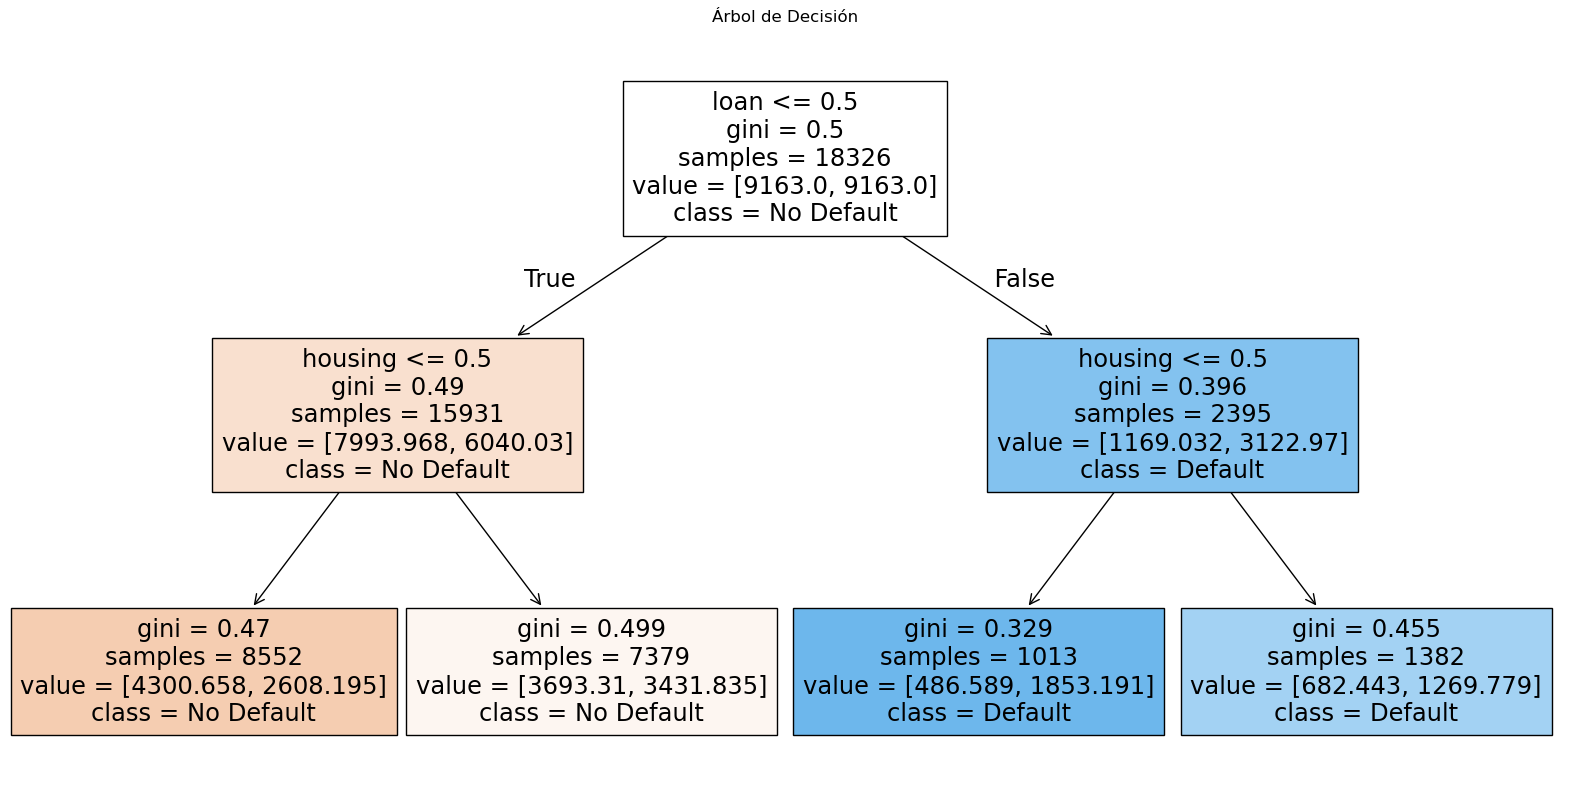

In [44]:
tree_model = DecisionTreeClassifier(max_depth=4,class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:,1]

print("=== Árbol de Decisión ===")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
print(f"AUC: {roc_auc_score(y_test, y_prob_tree):.4f}")

# Visualización del árbol
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=["No Default", "Default"], filled=True)
plt.title("Árbol de Decisión")
plt.show()

### ROC Curve

       y_true  p_logreg    p_tree
1968        0  0.454642  0.013552
17679       0  0.748844  0.026773
5923        0  0.748844  0.026773
1087        0  0.748844  0.026773
7172        0  0.405559  0.008887


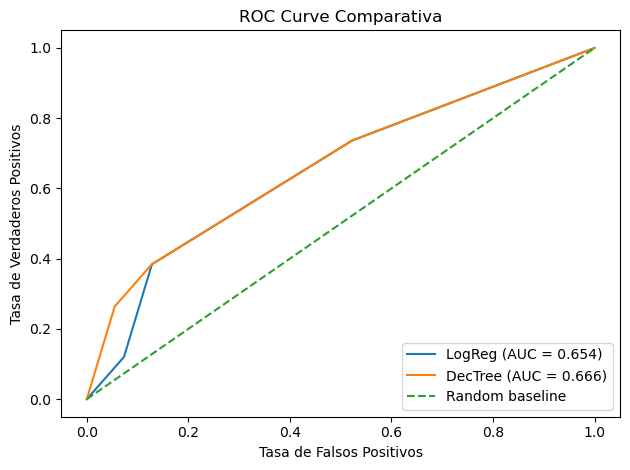

In [41]:
df_ROC = pd.DataFrame({ 
    'y_true': y_test,
    'p_logreg': y_prob,
    'p_tree': y_prob_tree
})

print(df_ROC.head())
# Calcula curvas ROC y AUC
fpr_lr, tpr_lr, _ = roc_curve(df_ROC['y_true'], df_ROC['p_logreg'])
fpr_dt, tpr_dt, _ = roc_curve(df_ROC['y_true'], df_ROC['p_tree'])
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)

# Dibuja
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'DecTree (AUC = {auc_dt:.3f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random baseline')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('ROC Curve Comparativa')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Lift Chart (ganancias)

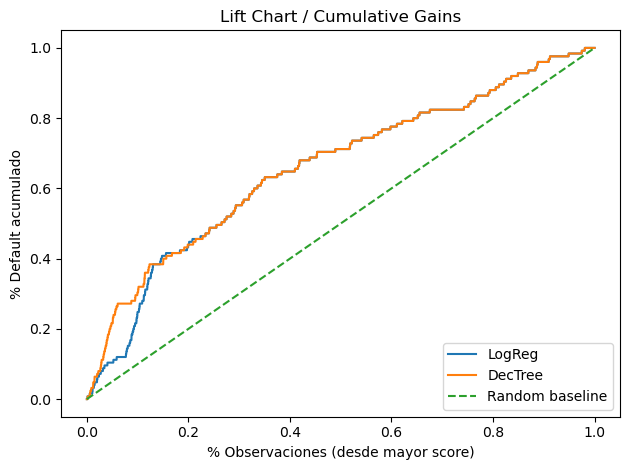

In [42]:
def cumulative_gains(y_true, y_score, n_bins=10):
    dfc = pd.DataFrame({'y': y_true, 'score': y_score})
    dfc = dfc.sort_values('score', ascending=False).reset_index(drop=True)
    dfc['cum_default'] = dfc['y'].cumsum()
    dfc['cum_pct_obs'] = (np.arange(len(dfc)) + 1) / len(dfc)
    dfc['cum_pct_def'] = dfc['cum_default'] / dfc['y'].sum()
    return dfc

# Genera curvas
cg_lr = cumulative_gains(df_ROC['y_true'], df_ROC['p_logreg'])
cg_dt = cumulative_gains(df_ROC['y_true'], df_ROC['p_tree'])

plt.figure()
plt.plot(cg_lr['cum_pct_obs'], cg_lr['cum_pct_def'], label='LogReg')
plt.plot(cg_dt['cum_pct_obs'], cg_dt['cum_pct_def'], label='DecTree')
plt.plot([0,1], [0,1], linestyle='--', label='Random baseline')
plt.xlabel('% Observaciones (desde mayor score)')
plt.ylabel('% Default acumulado')
plt.title('Lift Chart / Cumulative Gains')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Curva riesgo saldo

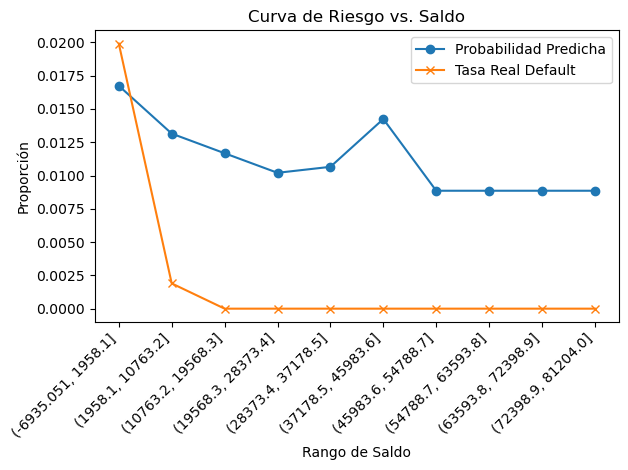

In [54]:
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(df_ROC['p_logreg'], df_ROC['y_true'])

# Probabilidades recalibradas
df_ROC['p_logreg_calibrated'] = iso.transform(df_ROC['p_logreg'])

# Definir bins de balance (p. ej. 15 rangos )
df_ROC['balance_bin'] = pd.cut(df['balance'], bins=10)

# Para cada bin, promedio de probabilidad y tasa real
summary = df_ROC.groupby('balance_bin').agg(
    avg_pred_proba = ('p_logreg_calibrated', 'mean'),
    real_default_rate = ('y_true', 'mean')
).reset_index()

plt.figure()
plt.plot(summary['balance_bin'].astype(str), summary['avg_pred_proba'], marker='o', label='Probabilidad Predicha')
plt.plot(summary['balance_bin'].astype(str), summary['real_default_rate'], marker='x', label='Tasa Real Default')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Rango de Saldo')
plt.ylabel('Proporción')
plt.title('Curva de Riesgo vs. Saldo')
plt.legend()
plt.tight_layout()
plt.show()